In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
tf.config.list_physical_devices('GPU')
import plotly.io as pio
import os
import shutil
import plotly.graph_objs as go
from ipywidgets import Output, VBox
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense,Flatten
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import random
import matplotlib.pyplot as plt

TensorFlow version: 2.12.0


In [2]:
#pip install -U kaleido PyPDF2

# KLARLACK

In [3]:
df_csv = pd.read_csv('2023_10_17_icps_product_id_404_run_id_794_experiment_id_1_to_12.csv', skiprows = 7)

labels = pd.read_csv('./labels_301023.csv')
labels = labels[labels['row'] != 'None']
labels = labels[labels['row'] != 'Aussortieren']
print(len(labels))

df_csv = df_csv.rename(columns={'Product ID [  ]': 'product_id', 'Run ID [  ]': 'run_id', 'Experiment ID [  ]': 'experiment_id',
                    'Trial ID [  ]': 'trial_id', 'x-Position [ m ]': 'x_position', 'x-Force [ N ]': 'x_force'
                    , 'y-Force [ N ]': 'y_force', 'z-Force [ N ]': 'z_force'})

df_csv1 = df_csv[df_csv["product_id"] == 404]
df_csv1 = df_csv[df_csv["run_id"] == 794]

df_csv2 = df_csv[df_csv["product_id"] == 404]
df_csv2 = df_csv[df_csv["run_id"] == 795]
df_csv2["run_id"] = 794
df_csv2["experiment_id"] = 4
df_csv = pd.concat([df_csv1, df_csv2])

peak_dfs = []
for run_id in df_csv["run_id"].unique():
    df_temp2 = df_csv[df_csv["run_id"] == run_id]
    
    for experiment_id in df_temp2["experiment_id"].unique():
        df_temp3 = df_temp2[df_temp2["experiment_id"] == experiment_id]
        
        for trial_id in df_temp3["trial_id"].unique():
            df_temp4 = df_temp3[df_temp3["trial_id"] == trial_id]
            
            if len(df_temp4) > 1:
                peak_dfs.append(df_temp4[["run_id", "experiment_id", "trial_id", 'x_position', 'x_force', 'y_force', 'z_force']])            
print("1", len(peak_dfs))
filtered_peak_dfs = []
for i, item in enumerate(peak_dfs):
    flipped_df = item[::-1]
    filtered_df_temp = flipped_df[flipped_df['x_position'] > 20.0001].reset_index(drop=True)
    
    if len(filtered_df_temp) > 0:
        
        peak_row_temp = filtered_df_temp['x_position'].idxmax()
        
        peak_row_data_temp = filtered_df_temp.loc[:peak_row_temp-1]
        
        filtered_df_temp2 = filtered_df_temp.loc[peak_row_temp:]
        filtered_df_temp2 = filtered_df_temp2[::-1]
        condition = filtered_df_temp2['x_force'] >= 0
        
        extracted_rows = filtered_df_temp2.loc[:condition.idxmax()]
        
        if (extracted_rows['x_position'] >= 99.9).all():
            filtered_peak_dfs1.append(pd.concat([peak_row_data_temp, extracted_rows]))
        else:
            filtered_peak_dfs.append(peak_row_data_temp)  
        #filtered_peak_dfs.append(filtered_df_temp2)    
print("2", len(filtered_peak_dfs))


max_length = max(len(df) for df in filtered_peak_dfs)
print(max_length)
for idx, df in enumerate(filtered_peak_dfs):
    if len(df) == max_length:
        max_df_id = idx
        break
max_length_df = filtered_peak_dfs[max_df_id]
print("max df id", max_df_id)

padded_dataframes = []
for df in filtered_peak_dfs:
    padding_size = 519 - len(df) #padding_size - len(df) # check classification
    if padding_size >= 0:
        try:
            padded_df = pd.DataFrame(np.pad(df.values, ((0, padding_size), (0, 0)), mode='edge'), columns=df.columns)
        except:
            pass
        padded_df['index'] = padded_df.index
    else:
        padded_df = df.sample(n=519, random_state=42).sort_index()
    padded_dataframes.append(padded_df.reset_index(drop=True))

93


<ipython-input-3-0cf61a4d6ef8>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_csv2["run_id"] = 794
<ipython-input-3-0cf61a4d6ef8>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_csv2["experiment_id"] = 4


1 120
2 120
555
max df id 68


87
519


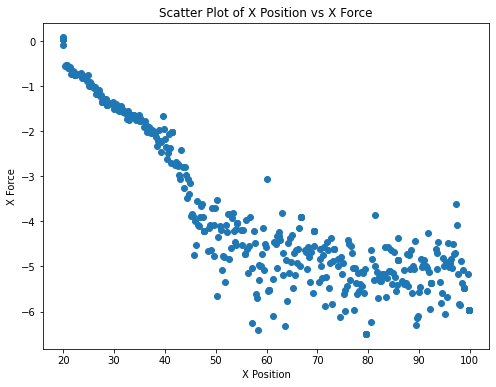

In [4]:
random_number = random.randint(0, len(padded_dataframes) - 1)  # assuming padded_dataframes is a list or a compatible data structure
print(random_number)
df_show = padded_dataframes[random_number]
print(len(df_show))

plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.scatter(df_show["x_position"], df_show["x_force"])
plt.xlabel('X Position')
plt.ylabel('X Force')
plt.title('Scatter Plot of X Position vs X Force')
plt.show()

In [5]:
lengths = set()
padded_dataframes_with_labels = []
for item in padded_dataframes:
    lengths.add(len(item))
    
    run_id = item["run_id"].unique()[0],
    trial_id = item["trial_id"].unique()[0],
    experiment_id = item["experiment_id"].unique()[0]
    
    #print("RUN_ID:", run_id,"experiment_id:",  experiment_id,"trial_id:", trial_id)

    individual = labels[labels["run_id"] == run_id]
    individual = individual[individual["experiment_id"] == experiment_id]
    individual = individual[individual["trial_id"] == trial_id]
    try:
        individual['row'].iloc[0].isnumeric()
    except:
        continue
    if individual['row'].iloc[0].isnumeric():
        row_value = int(individual['row'])
        padded_dataframes_with_labels.append((item, row_value))
    else:
        continue
print(lengths)
print(len(padded_dataframes_with_labels))

{519}
93


273


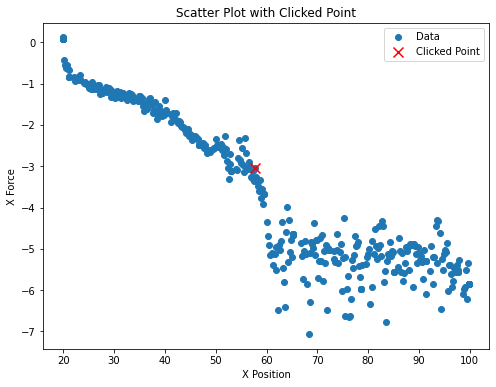

In [6]:
random_number = random.randint(0, len(padded_dataframes_with_labels) - 1)
df_show = padded_dataframes_with_labels[random_number][0]
label = padded_dataframes_with_labels[random_number][1]
print(label)

plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

# Scatter plot of the data
plt.scatter(df_show["x_position"], df_show["x_force"], label='Data')

# Get the target row based on the label
target_row = df_show.iloc[label]

# Plot the clicked point as a red 'X'
plt.scatter(target_row["x_position"], target_row["x_force"], color='red', marker='x', s=100, label='Clicked Point')

plt.xlabel('X Position')
plt.ylabel('X Force')
plt.title('Scatter Plot with Clicked Point')
plt.legend()
plt.show()

# Regression

In [7]:
regression_model = tf.keras.models.load_model('Polke_only_Regression_best_model.h5')

In [8]:
tensor_X = []
tensor_y = []
for item in padded_dataframes_with_labels:
    #df_temp = item[0][['x_force', 'y_force', 'z_force']].copy()
    #df_temp = item[0][['x_force', 'z_force']].copy()
    df_temp = item[0][['x_force']].copy()
    a = df_temp.to_numpy().astype(np.float32)
    tensor_X.append(a)
    tensor_y.append(item[1])
print(len(tensor_X))
print(len(tensor_y))

# train test split
X_train, X_temp, y_train, y_temp = train_test_split(np.array(tensor_X), np.array(tensor_y), test_size=0.5, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.9, shuffle=True)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_val.shape , y_val.shape)

93
93
(46, 519, 1) (43, 519, 1) (46,) (43,) (4, 519, 1) (4,)


In [9]:
# Define a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'Finetuned_Regression_best_model.h5',              # Filepath to save the model
    monitor='val_loss',           # Metric to monitor
    save_best_only=True,          # Save only the best model
    save_weights_only=False,      # Save the entire model (including architecture)
    mode='min',                   # 'min' or 'max' depending on the monitored metric
    verbose=1                      # Print messages about saving progress
)

# Train the model
history = regression_model.fit(X_train, y_train, epochs=200, batch_size=16, validation_data=(X_val, y_val), callbacks=[checkpoint])

Epoch 1/200
3/3 [==============================] - ETA: 0s - loss: 316.1405
Epoch 1: val_loss improved from inf to 246.73840, saving model to Finetuned_Regression_best_model.h5
3/3 [==============================] - 4s 598ms/step - loss: 316.1405 - val_loss: 246.7384
Epoch 2/200
3/3 [==============================] - ETA: 0s - loss: 160.5523
Epoch 2: val_loss did not improve from 246.73840
3/3 [==============================] - 1s 324ms/step - loss: 160.5523 - val_loss: 305.6447
Epoch 3/200
3/3 [==============================] - ETA: 0s - loss: 86.1635
Epoch 3: val_loss did not improve from 246.73840
3/3 [==============================] - 1s 276ms/step - loss: 86.1635 - val_loss: 292.4835
Epoch 4/200
2/3 [===================>..........] - ETA: 0s - loss: 119.9869
Epoch 4: val_loss did not improve from 246.73840
3/3 [==============================] - 1s 325ms/step - loss: 97.4997 - val_loss: 326.3845
Epoch 5/200
3/3 [==============================] - ETA: 0s - loss: 71.0773
Epoch 5: val

Epoch 37/200
3/3 [==============================] - ETA: 0s - loss: 19.7816
Epoch 37: val_loss did not improve from 47.30805
3/3 [==============================] - 1s 286ms/step - loss: 19.7816 - val_loss: 56.4275
Epoch 38/200
3/3 [==============================] - ETA: 0s - loss: 25.7739
Epoch 38: val_loss did not improve from 47.30805
3/3 [==============================] - 1s 252ms/step - loss: 25.7739 - val_loss: 61.2318
Epoch 39/200
2/3 [===================>..........] - ETA: 0s - loss: 15.4034
Epoch 39: val_loss did not improve from 47.30805
3/3 [==============================] - 1s 332ms/step - loss: 27.7763 - val_loss: 117.4621
Epoch 40/200
3/3 [==============================] - ETA: 0s - loss: 23.0634
Epoch 40: val_loss improved from 47.30805 to 20.82540, saving model to Finetuned_Regression_best_model.h5
3/3 [==============================] - 1s 345ms/step - loss: 23.0634 - val_loss: 20.8254
Epoch 41/200
3/3 [==============================] - ETA: 0s - loss: 23.7238
Epoch 41: 

2/3 [===================>..........] - ETA: 0s - loss: 9.4837 
Epoch 74: val_loss did not improve from 5.39980
3/3 [==============================] - 1s 334ms/step - loss: 11.3681 - val_loss: 5.7341
Epoch 75/200
2/3 [===================>..........] - ETA: 0s - loss: 13.8236
Epoch 75: val_loss did not improve from 5.39980
3/3 [==============================] - 1s 377ms/step - loss: 17.4219 - val_loss: 24.0075
Epoch 76/200
3/3 [==============================] - ETA: 0s - loss: 15.8594
Epoch 76: val_loss did not improve from 5.39980
3/3 [==============================] - 1s 341ms/step - loss: 15.8594 - val_loss: 6.2982
Epoch 77/200
3/3 [==============================] - ETA: 0s - loss: 12.5585
Epoch 77: val_loss did not improve from 5.39980
3/3 [==============================] - 1s 307ms/step - loss: 12.5585 - val_loss: 14.7295
Epoch 78/200
3/3 [==============================] - ETA: 0s - loss: 11.7451
Epoch 78: val_loss did not improve from 5.39980
3/3 [==============================] - 

Epoch 112/200
3/3 [==============================] - ETA: 0s - loss: 11.0537
Epoch 112: val_loss did not improve from 5.28835
3/3 [==============================] - 1s 345ms/step - loss: 11.0537 - val_loss: 7.6076
Epoch 113/200
3/3 [==============================] - ETA: 0s - loss: 10.1361
Epoch 113: val_loss did not improve from 5.28835
3/3 [==============================] - 1s 268ms/step - loss: 10.1361 - val_loss: 8.8684
Epoch 114/200
3/3 [==============================] - ETA: 0s - loss: 9.8434
Epoch 114: val_loss did not improve from 5.28835
3/3 [==============================] - 1s 215ms/step - loss: 9.8434 - val_loss: 13.6529
Epoch 115/200
3/3 [==============================] - ETA: 0s - loss: 13.3203
Epoch 115: val_loss did not improve from 5.28835
3/3 [==============================] - 1s 260ms/step - loss: 13.3203 - val_loss: 7.8865
Epoch 116/200
3/3 [==============================] - ETA: 0s - loss: 11.2612
Epoch 116: val_loss did not improve from 5.28835
3/3 [==============

3/3 [==============================] - ETA: 0s - loss: 6.9365
Epoch 150: val_loss did not improve from 5.28835
3/3 [==============================] - 1s 374ms/step - loss: 6.9365 - val_loss: 7.5809
Epoch 151/200
3/3 [==============================] - ETA: 0s - loss: 7.2850
Epoch 151: val_loss did not improve from 5.28835
3/3 [==============================] - 1s 260ms/step - loss: 7.2850 - val_loss: 8.5020
Epoch 152/200
3/3 [==============================] - ETA: 0s - loss: 6.3221
Epoch 152: val_loss did not improve from 5.28835
3/3 [==============================] - 1s 274ms/step - loss: 6.3221 - val_loss: 14.0072
Epoch 153/200
3/3 [==============================] - ETA: 0s - loss: 10.2581
Epoch 153: val_loss did not improve from 5.28835
3/3 [==============================] - 1s 268ms/step - loss: 10.2581 - val_loss: 10.1862
Epoch 154/200
3/3 [==============================] - ETA: 0s - loss: 13.6188
Epoch 154: val_loss did not improve from 5.28835
3/3 [==============================]

3/3 [==============================] - 1s 340ms/step - loss: 3.9445 - val_loss: 9.8247
Epoch 189/200
3/3 [==============================] - ETA: 0s - loss: 4.0015
Epoch 189: val_loss did not improve from 5.28835
3/3 [==============================] - 1s 277ms/step - loss: 4.0015 - val_loss: 10.4300
Epoch 190/200
3/3 [==============================] - ETA: 0s - loss: 8.1770
Epoch 190: val_loss did not improve from 5.28835
3/3 [==============================] - 1s 302ms/step - loss: 8.1770 - val_loss: 10.2510
Epoch 191/200
3/3 [==============================] - ETA: 0s - loss: 9.8599 
Epoch 191: val_loss did not improve from 5.28835
3/3 [==============================] - 1s 296ms/step - loss: 9.8599 - val_loss: 7.8252
Epoch 192/200
3/3 [==============================] - ETA: 0s - loss: 5.5139
Epoch 192: val_loss did not improve from 5.28835
3/3 [==============================] - 1s 284ms/step - loss: 5.5139 - val_loss: 6.7997
Epoch 193/200
3/3 [==============================] - ETA: 0s -

In [10]:
# Evaluate the model on the test data
loss = regression_model.evaluate(X_test, y_test)
# Print the evaluation result
print("Loss: ", loss)

2/2 [==============================] - 0s 39ms/step - loss: 82.1605
Loss:  82.16046905517578


In [11]:
# Predict
predictions = regression_model.predict(X_test)
predictions = np.round(predictions)
print(mean_squared_error(predictions, y_test))
print(mean_absolute_error(predictions, y_test))
# Print the arrays side by side
# for a, b in zip(predictions, np.round(np.array(tensor_y))):
#     print(f"{int(a)} {b}")

2/2 [==============================] - 0s 29ms/step
81.93023255813954
5.744186046511628


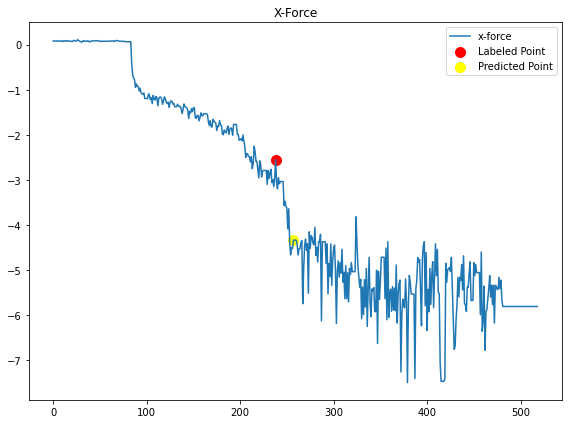

##################### NEXT #####################


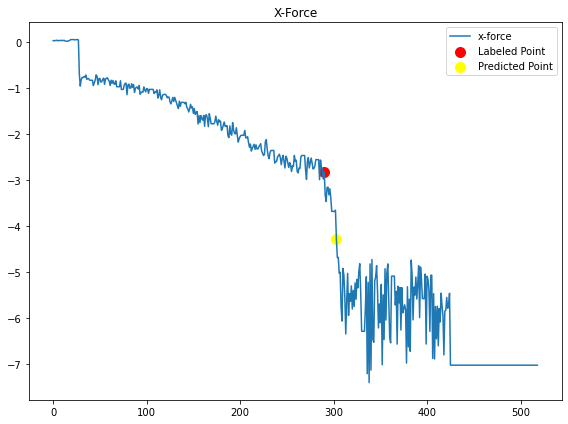

##################### NEXT #####################


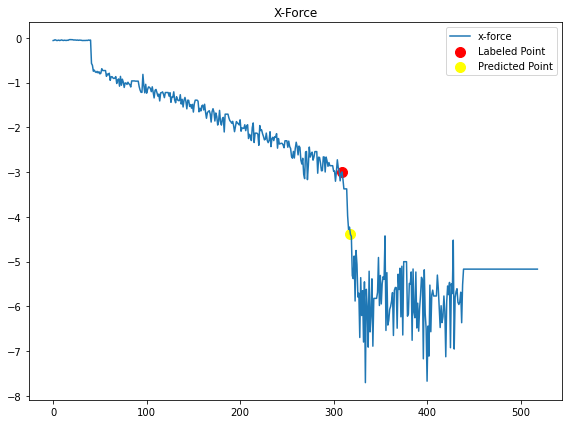

##################### NEXT #####################


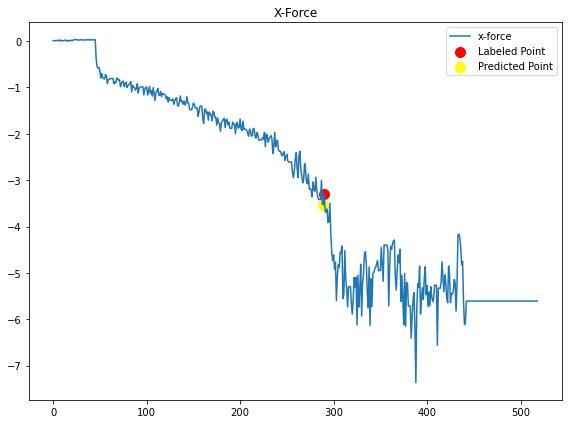

##################### NEXT #####################


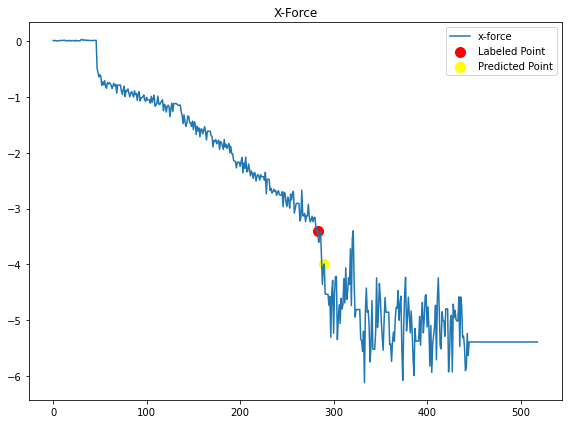

##################### NEXT #####################


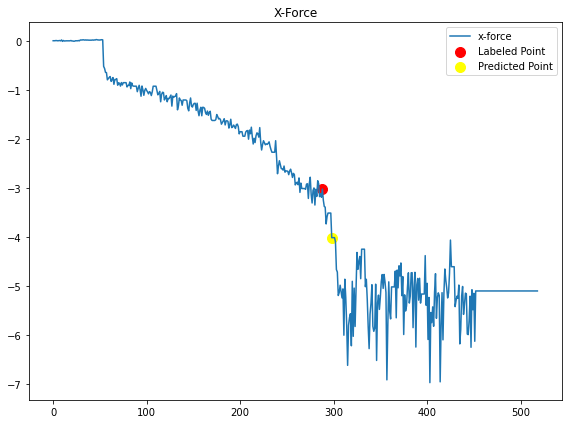

##################### NEXT #####################


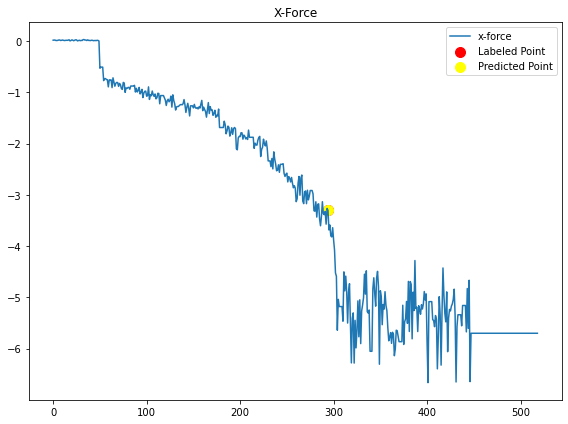

##################### NEXT #####################


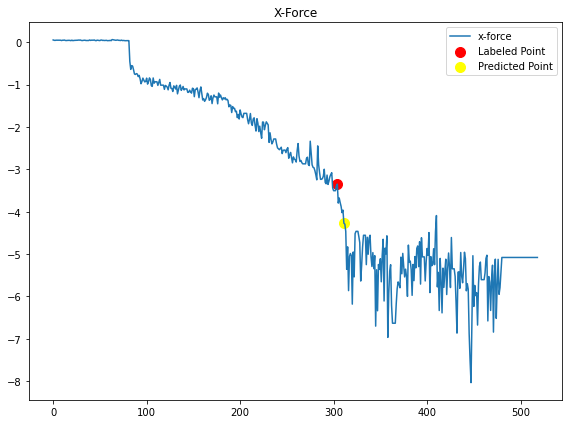

##################### NEXT #####################


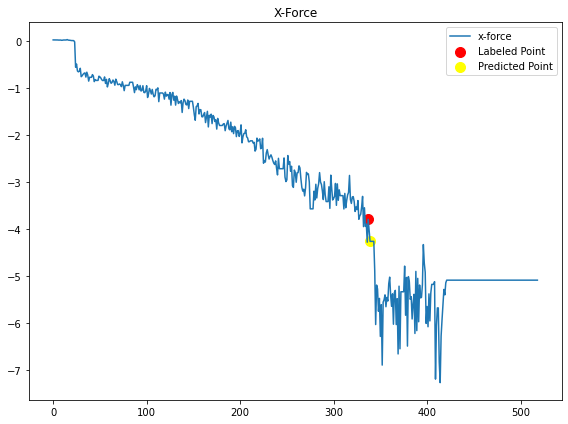

##################### NEXT #####################


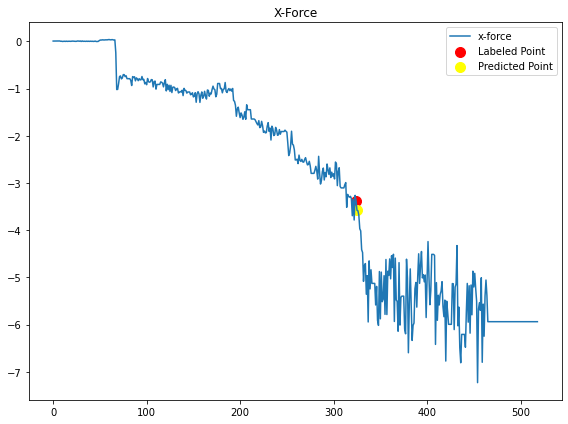

##################### NEXT #####################


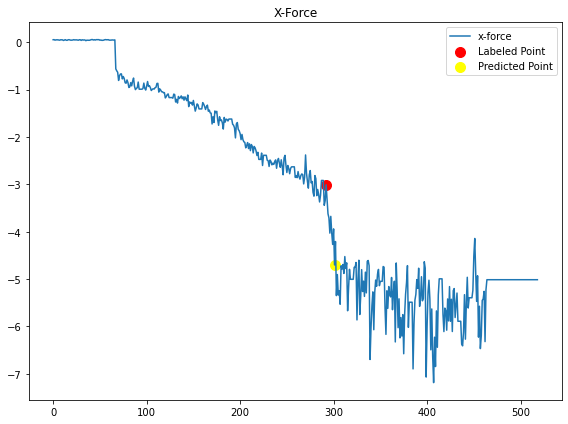

##################### NEXT #####################


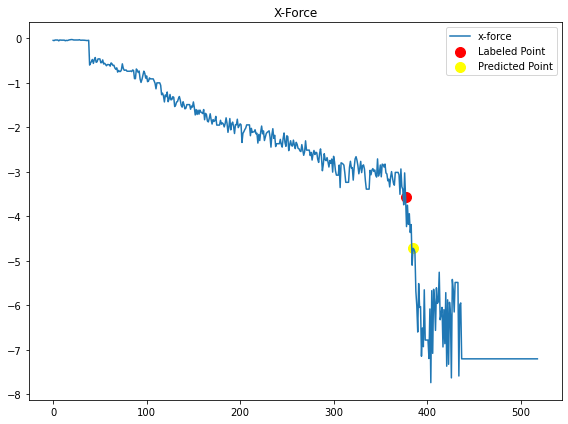

##################### NEXT #####################


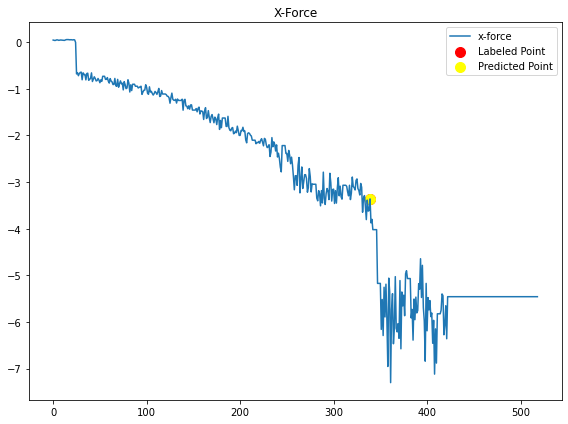

##################### NEXT #####################


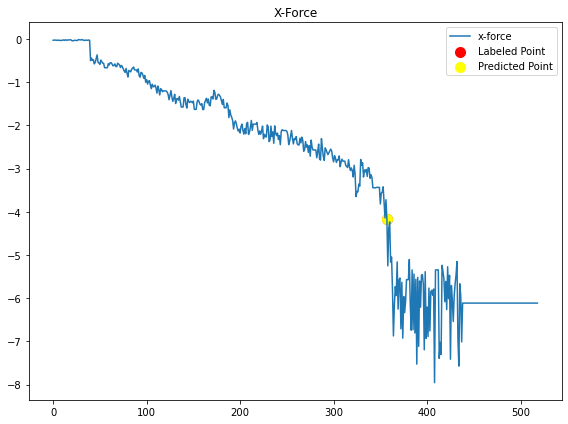

##################### NEXT #####################


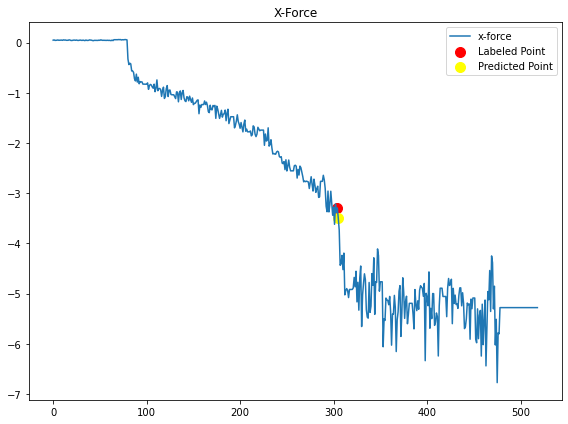

##################### NEXT #####################


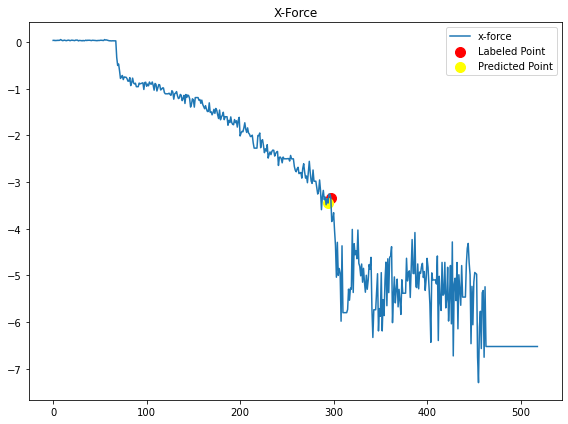

##################### NEXT #####################


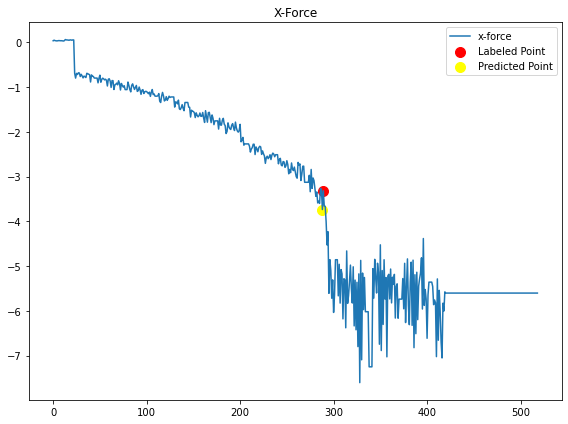

##################### NEXT #####################


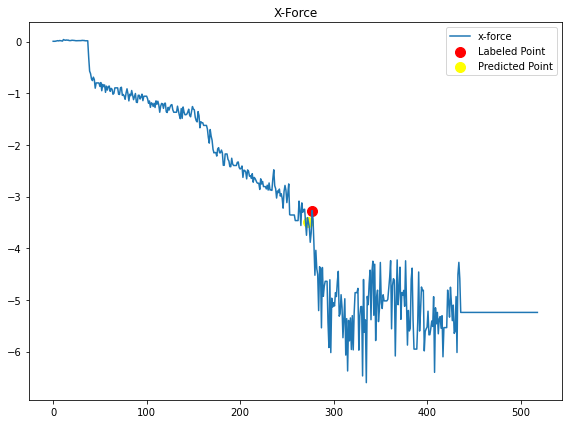

##################### NEXT #####################


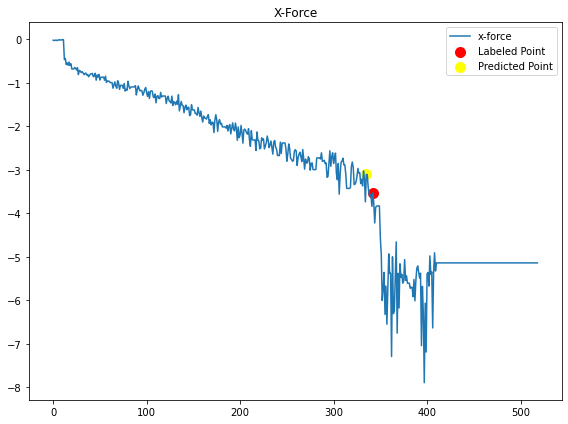

##################### NEXT #####################


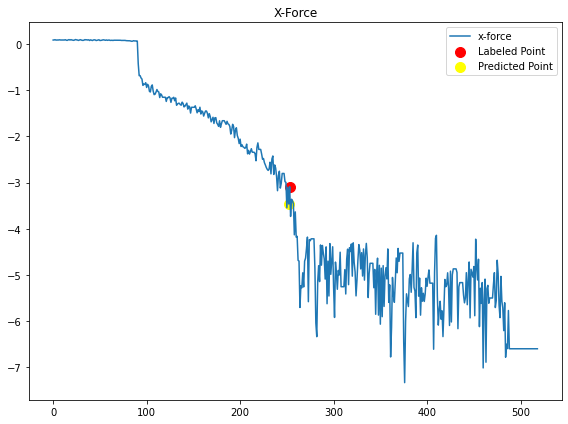

##################### NEXT #####################


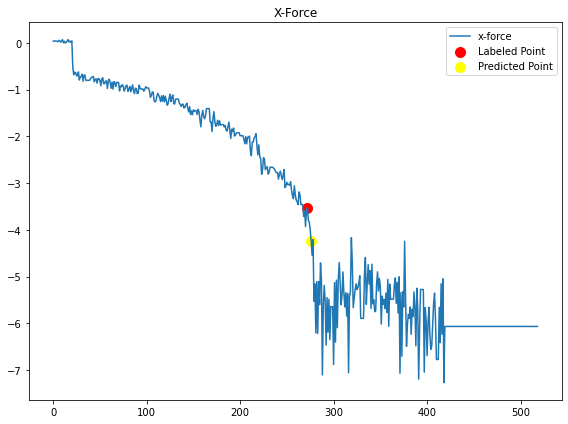

##################### NEXT #####################


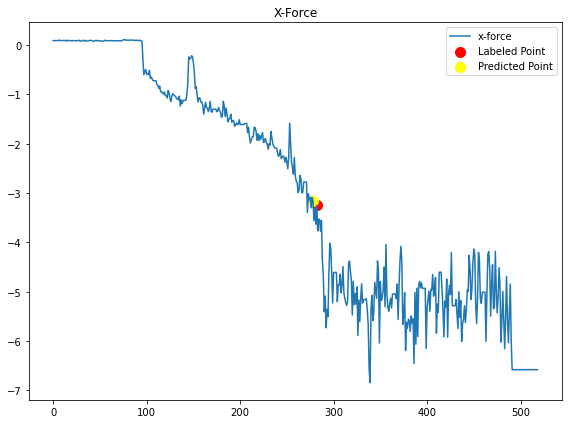

##################### NEXT #####################


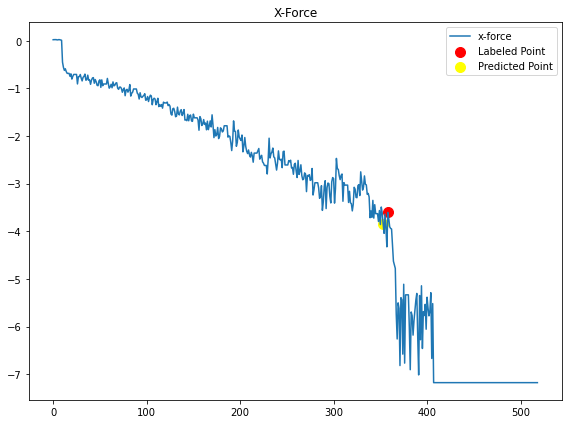

##################### NEXT #####################


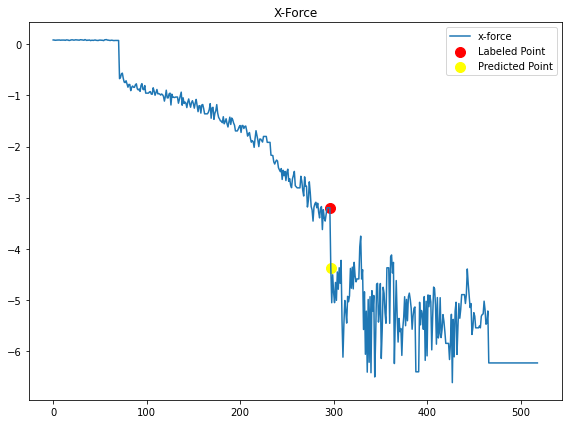

##################### NEXT #####################


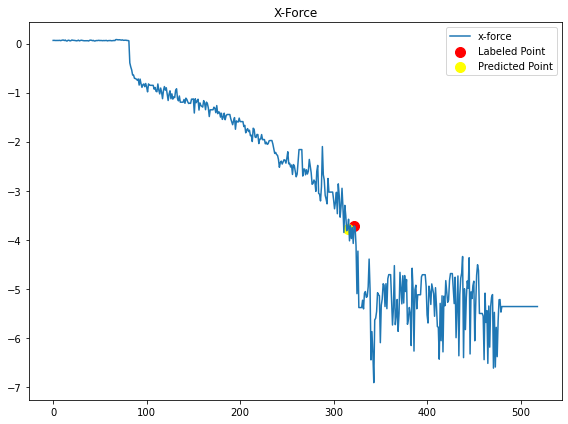

##################### NEXT #####################


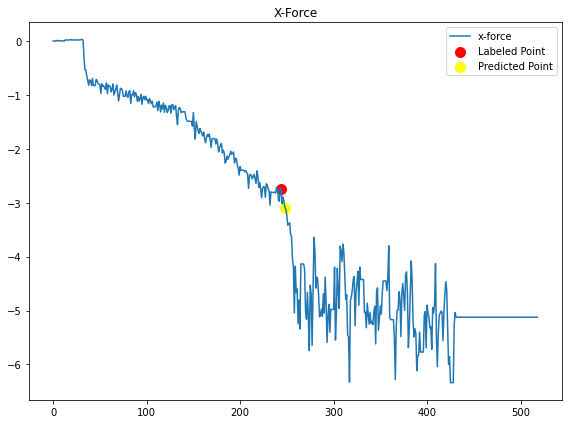

##################### NEXT #####################


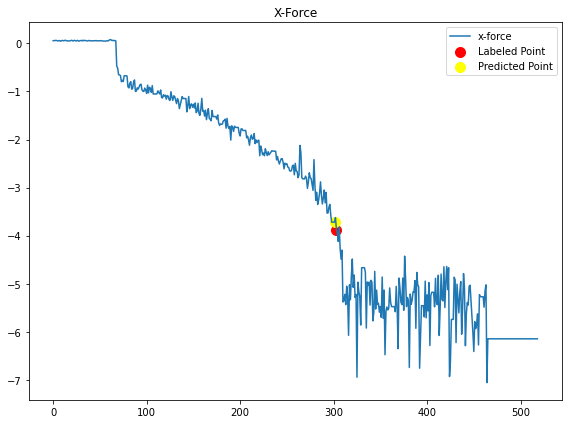

##################### NEXT #####################


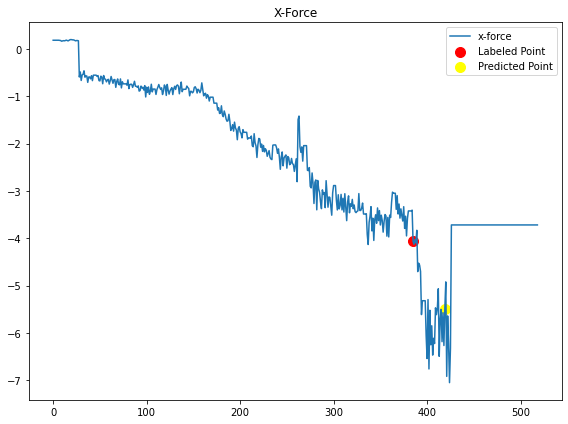

##################### NEXT #####################


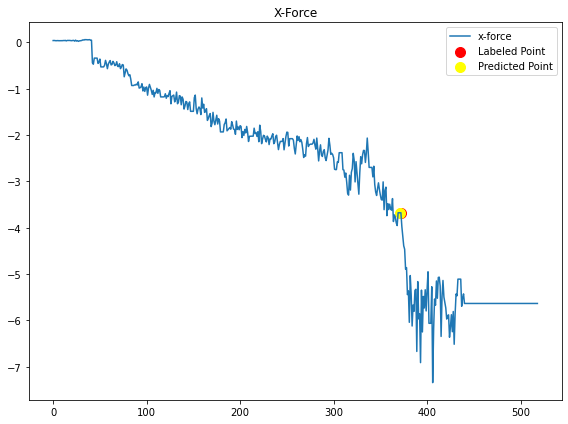

##################### NEXT #####################


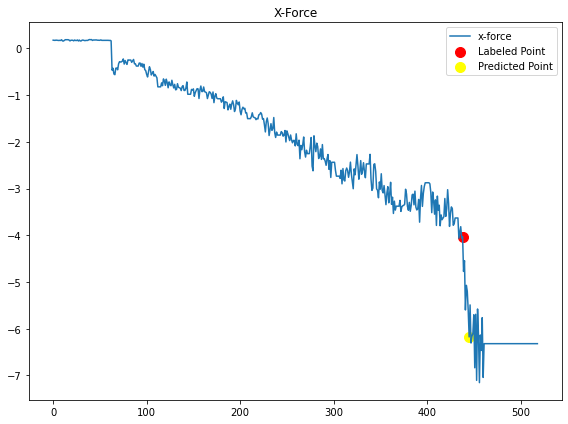

##################### NEXT #####################


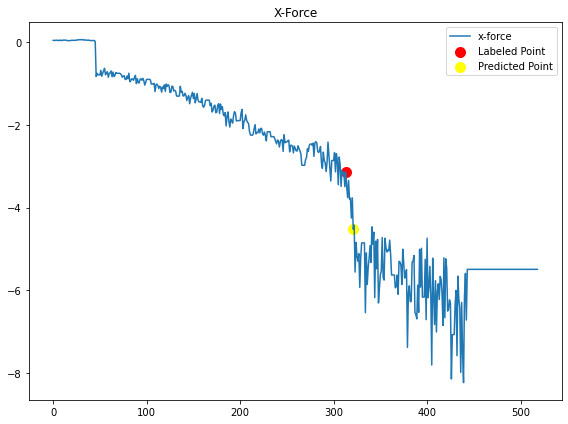

##################### NEXT #####################


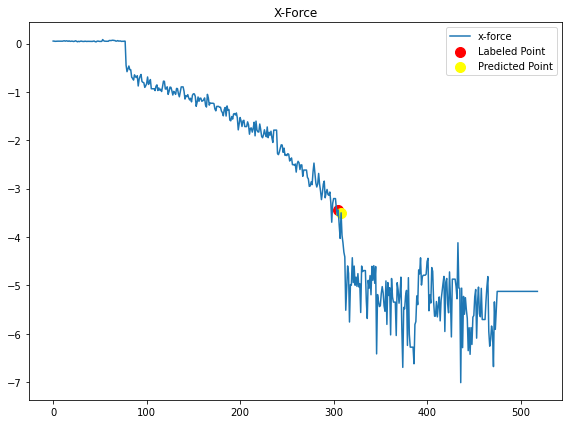

##################### NEXT #####################


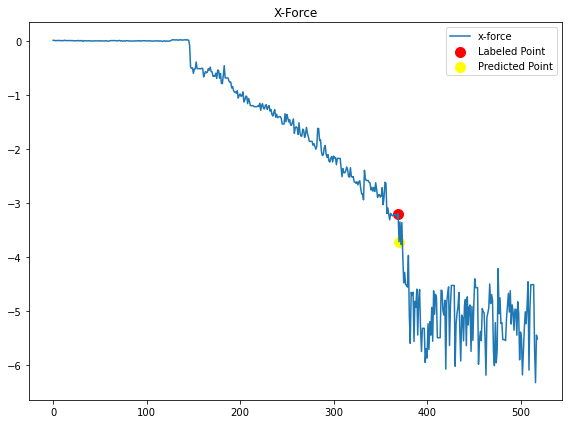

##################### NEXT #####################


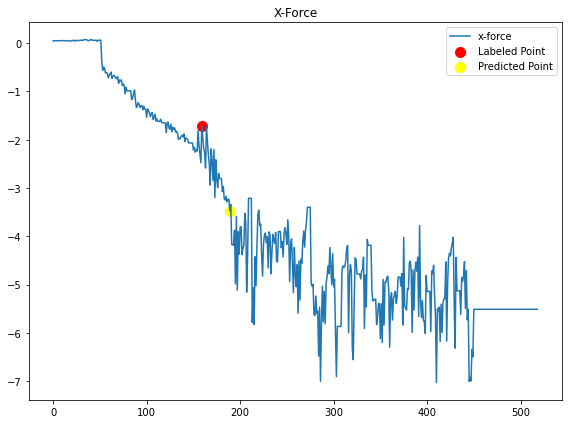

##################### NEXT #####################


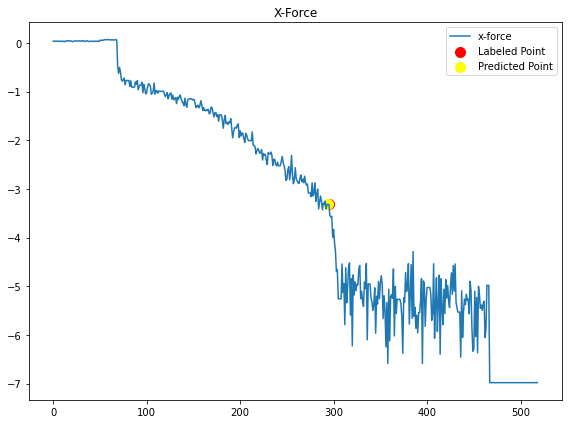

##################### NEXT #####################


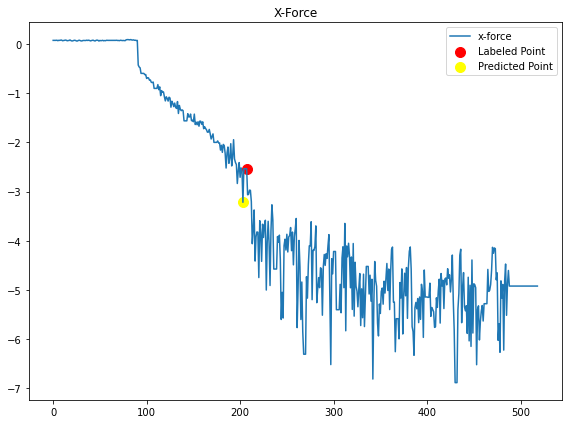

##################### NEXT #####################


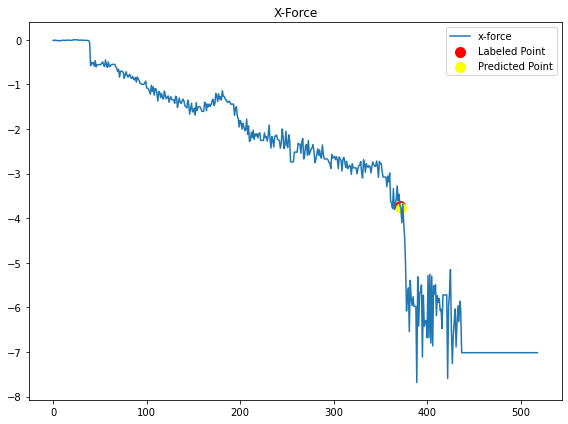

##################### NEXT #####################


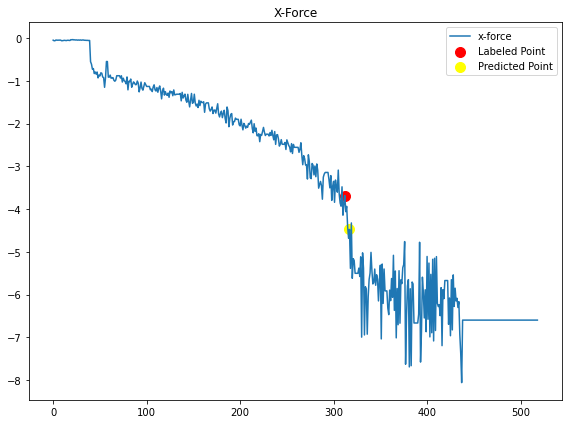

##################### NEXT #####################


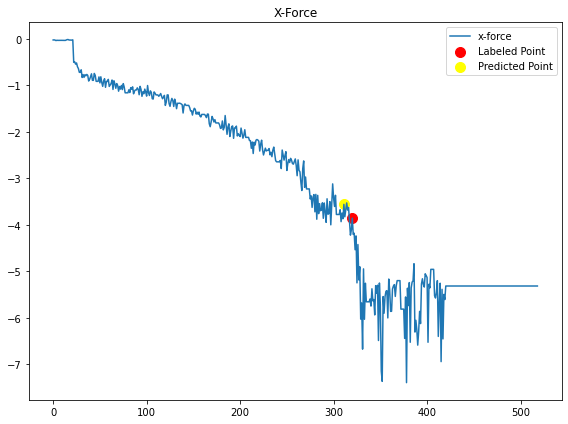

##################### NEXT #####################


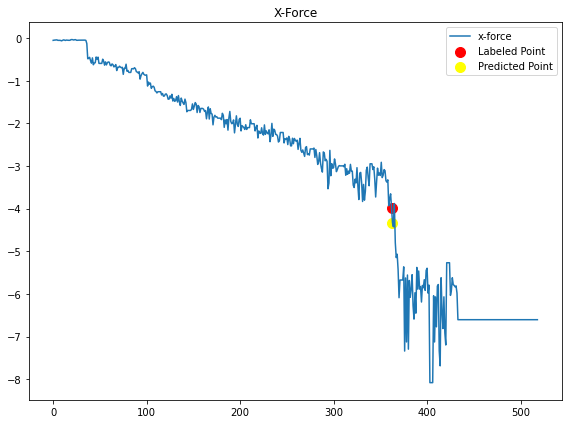

##################### NEXT #####################


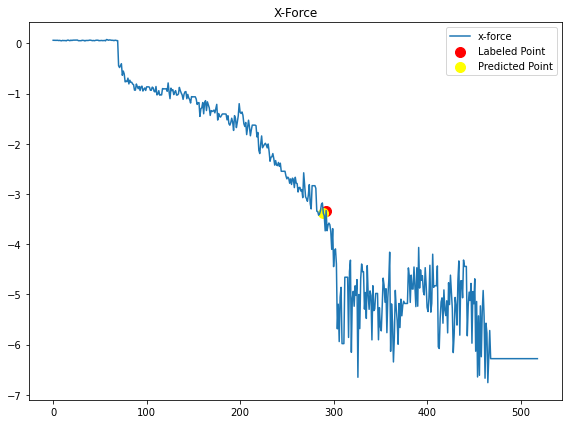

##################### NEXT #####################


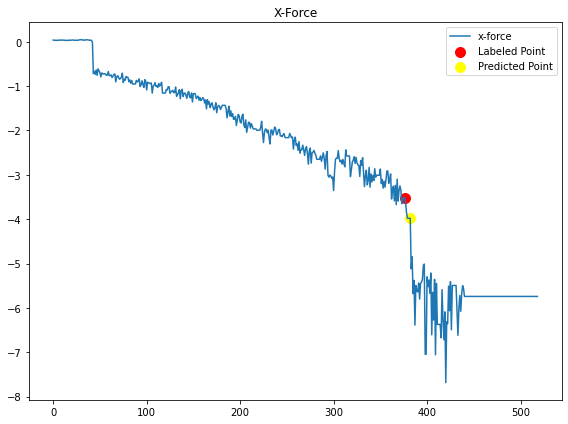

##################### NEXT #####################


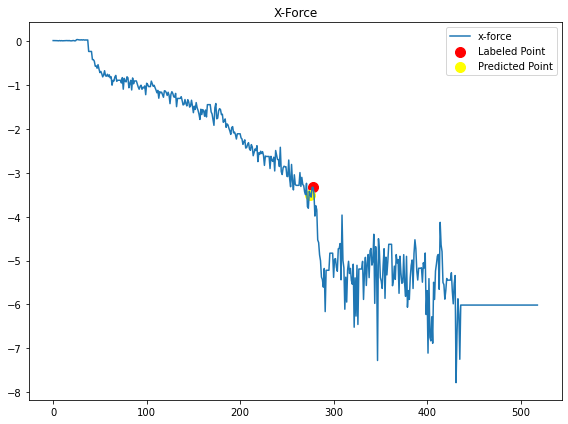

##################### NEXT #####################


In [12]:
for i, item in enumerate(predictions):
    x_force = X_test[i][:, 0]
    label = y_test[i]
    item = int(item[0])

    plt.figure(figsize=(8, 6))
    
    plt.plot(np.arange(len(x_force)), x_force, label='x-force')
    plt.scatter(label, x_force[label], color='red', label='Labeled Point', s=100)
    plt.scatter(item, x_force[item], color='yellow', label='Predicted Point', s=100)
    plt.title('X-Force')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    print("##################### NEXT #####################")

# Classification

In [13]:
df_csv = pd.read_csv('2023_10_17_icps_product_id_404_run_id_794_experiment_id_1_to_12.csv', skiprows = 7)

labels = pd.read_csv('./labels_301023.csv')
labels = labels[labels['row'] != 'Aussortieren']
print(len(labels))

df_csv = df_csv.rename(columns={'Product ID [  ]': 'product_id', 'Run ID [  ]': 'run_id', 'Experiment ID [  ]': 'experiment_id',
                    'Trial ID [  ]': 'trial_id', 'x-Position [ m ]': 'x_position', 'x-Force [ N ]': 'x_force'
                    , 'y-Force [ N ]': 'y_force', 'z-Force [ N ]': 'z_force'})

df_csv1 = df_csv[df_csv["product_id"] == 404]
df_csv1 = df_csv[df_csv["run_id"] == 794]

df_csv2 = df_csv[df_csv["product_id"] == 404]
df_csv2 = df_csv[df_csv["run_id"] == 795]
df_csv2["run_id"] = 794
df_csv2["experiment_id"] = 4
df_csv = pd.concat([df_csv1, df_csv2])

peak_dfs = []
for run_id in df_csv["run_id"].unique():
    df_temp2 = df_csv[df_csv["run_id"] == run_id]
    
    for experiment_id in df_temp2["experiment_id"].unique():
        df_temp3 = df_temp2[df_temp2["experiment_id"] == experiment_id]
        
        for trial_id in df_temp3["trial_id"].unique():
            df_temp4 = df_temp3[df_temp3["trial_id"] == trial_id]
            
            if len(df_temp4) > 1:
                peak_dfs.append(df_temp4[["run_id", "experiment_id", "trial_id", 'x_position', 'x_force', 'y_force', 'z_force']])            
print("1", len(peak_dfs))
filtered_peak_dfs = []
for i, item in enumerate(peak_dfs):
    flipped_df = item[::-1]
    filtered_df_temp = flipped_df[flipped_df['x_position'] > 20.0001].reset_index(drop=True)
    
    if len(filtered_df_temp) > 0:
        
        peak_row_temp = filtered_df_temp['x_position'].idxmax()
        
        peak_row_data_temp = filtered_df_temp.loc[:peak_row_temp-1]
        
        filtered_df_temp2 = filtered_df_temp.loc[peak_row_temp:]
        filtered_df_temp2 = filtered_df_temp2[::-1]
        condition = filtered_df_temp2['x_force'] >= 0
        
        extracted_rows = filtered_df_temp2.loc[:condition.idxmax()]
        
        if (extracted_rows['x_position'] >= 99.9).all():
            filtered_peak_dfs1.append(pd.concat([peak_row_data_temp, extracted_rows]))
        else:
            filtered_peak_dfs.append(peak_row_data_temp)  
        #filtered_peak_dfs.append(filtered_df_temp2)    
print("2", len(filtered_peak_dfs))


max_length = max(len(df) for df in filtered_peak_dfs)
print(max_length)
for idx, df in enumerate(filtered_peak_dfs):
    if len(df) == max_length:
        max_df_id = idx
        break
max_length_df = filtered_peak_dfs[max_df_id]
print("max df id", max_df_id)

padded_dataframes = []
for df in filtered_peak_dfs:
    padding_size = 519 - len(df) #padding_size - len(df) # check classification
    if padding_size >= 0:
        try:
            padded_df = pd.DataFrame(np.pad(df.values, ((0, padding_size), (0, 0)), mode='edge'), columns=df.columns)
        except:
            pass
        padded_df['index'] = padded_df.index
    else:
        padded_df = df.sample(n=519, random_state=42).sort_index()
    padded_dataframes.append(padded_df.reset_index(drop=True))

120


<ipython-input-13-71e2b3e1b30c>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_csv2["run_id"] = 794
<ipython-input-13-71e2b3e1b30c>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_csv2["experiment_id"] = 4


1 120
2 120
555
max df id 68


In [14]:
X, y = [], []

for i,item in enumerate(padded_dataframes):
    Peak_df = item
    run_id = Peak_df["run_id"].unique()[0],
    trial_id = Peak_df["trial_id"].unique()[0],
    experiment_id = Peak_df["experiment_id"].unique()[0]
    
    
    indidvidual = labels[labels["run_id"] == run_id]
    indidvidual = indidvidual[indidvidual["experiment_id"] == experiment_id]
    indidvidual = indidvidual[indidvidual["trial_id"] == trial_id]
    
    X.append(Peak_df)
    y.append(indidvidual["row"].iloc[0])
    
print(len(padded_dataframes))
print(len(X))
print(len(y))

120
120
120


In [15]:
tensor_X = []
for item in X:
    item = item[['x_force']].copy()
    a = item.to_numpy().astype(np.float32)
    tensor_X.append(a)
    
y_class = np.where(np.array(y) == 'None', 0, 1).astype(int)
y_class

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(np.array(tensor_X), y_class, test_size=0.5, shuffle=True)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

# Check the class distribution in the train and test sets
train_class_counts = np.bincount(y_train)
test_class_counts = np.bincount(y_test)

print("Train class distribution:")
print(train_class_counts)

print("\nTest class distribution:")
print(test_class_counts)

(60, 519, 1) (60, 519, 1)
(60,) (60,)
Train class distribution:
[16 44]

Test class distribution:
[11 49]


In [17]:
classification_model = tf.keras.models.load_model('./Polke_only_Classification_best_model.h5')
# Define a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'Finetuned_Classification_best_model.h5',              # Filepath to save the model
    monitor='val_loss',           # Metric to monitor
    save_best_only=True,          # Save only the best model
    save_weights_only=False,      # Save the entire model (including architecture)
    mode='min',                   # 'min' or 'max' depending on the monitored metric
    verbose=1                      # Print messages about saving progress
)

# Train the model
history = classification_model.fit(X_train, y_train, epochs=200, batch_size=16, validation_data=(X_val, y_val), callbacks=[checkpoint])

Epoch 1/200
4/4 [==============================] - ETA: 0s - loss: 0.0139 - accuracy: 0.9833
Epoch 1: val_loss improved from inf to -6429.62402, saving model to Finetuned_Classification_best_model.h5
4/4 [==============================] - 4s 474ms/step - loss: 0.0139 - accuracy: 0.9833 - val_loss: -6429.6240 - val_accuracy: 0.0000e+00
Epoch 2/200
4/4 [==============================] - ETA: 0s - loss: 0.0131 - accuracy: 0.9833
Epoch 2: val_loss did not improve from -6429.62402
4/4 [==============================] - 1s 202ms/step - loss: 0.0131 - accuracy: 0.9833 - val_loss: -5040.8062 - val_accuracy: 0.0000e+00
Epoch 3/200
4/4 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 0.9833
Epoch 3: val_loss did not improve from -6429.62402
4/4 [==============================] - 1s 174ms/step - loss: 0.0170 - accuracy: 0.9833 - val_loss: -4096.5596 - val_accuracy: 0.0000e+00
Epoch 4/200
4/4 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000
Epoch 4:

4/4 [==============================] - ETA: 0s - loss: 5.5131e-05 - accuracy: 1.0000
Epoch 29: val_loss did not improve from -6429.62402
4/4 [==============================] - 1s 224ms/step - loss: 5.5131e-05 - accuracy: 1.0000 - val_loss: -3576.7947 - val_accuracy: 0.0000e+00
Epoch 30/200
3/4 [=====================>........] - ETA: 0s - loss: 3.3609e-05 - accuracy: 1.0000
Epoch 30: val_loss did not improve from -6429.62402
4/4 [==============================] - 1s 193ms/step - loss: 3.9992e-05 - accuracy: 1.0000 - val_loss: -3656.8535 - val_accuracy: 0.0000e+00
Epoch 31/200
4/4 [==============================] - ETA: 0s - loss: 6.8544e-05 - accuracy: 1.0000
Epoch 31: val_loss did not improve from -6429.62402
4/4 [==============================] - 1s 193ms/step - loss: 6.8544e-05 - accuracy: 1.0000 - val_loss: -3746.1777 - val_accuracy: 0.0000e+00
Epoch 32/200
4/4 [==============================] - ETA: 0s - loss: 3.8338e-05 - accuracy: 1.0000
Epoch 32: val_loss did not improve from -6

3/4 [=====================>........] - ETA: 0s - loss: 1.1754e-05 - accuracy: 1.0000
Epoch 57: val_loss did not improve from -6429.62402
4/4 [==============================] - 1s 208ms/step - loss: 1.6011e-05 - accuracy: 1.0000 - val_loss: -5376.3081 - val_accuracy: 0.0000e+00
Epoch 58/200
4/4 [==============================] - ETA: 0s - loss: 1.9807e-05 - accuracy: 1.0000
Epoch 58: val_loss did not improve from -6429.62402
4/4 [==============================] - 1s 220ms/step - loss: 1.9807e-05 - accuracy: 1.0000 - val_loss: -5414.9517 - val_accuracy: 0.0000e+00
Epoch 59/200
4/4 [==============================] - ETA: 0s - loss: 1.3584e-05 - accuracy: 1.0000
Epoch 59: val_loss did not improve from -6429.62402
4/4 [==============================] - 1s 237ms/step - loss: 1.3584e-05 - accuracy: 1.0000 - val_loss: -5457.7500 - val_accuracy: 0.0000e+00
Epoch 60/200
4/4 [==============================] - ETA: 0s - loss: 2.5696e-05 - accuracy: 1.0000
Epoch 60: val_loss did not improve from -6

4/4 [==============================] - ETA: 0s - loss: 7.1632e-06 - accuracy: 1.0000
Epoch 85: val_loss did not improve from -6429.62402
4/4 [==============================] - 1s 211ms/step - loss: 7.1632e-06 - accuracy: 1.0000 - val_loss: -6332.6455 - val_accuracy: 0.0000e+00
Epoch 86/200
4/4 [==============================] - ETA: 0s - loss: 6.8364e-06 - accuracy: 1.0000
Epoch 86: val_loss did not improve from -6429.62402
4/4 [==============================] - 1s 224ms/step - loss: 6.8364e-06 - accuracy: 1.0000 - val_loss: -6379.2803 - val_accuracy: 0.0000e+00
Epoch 87/200
4/4 [==============================] - ETA: 0s - loss: 4.0493e-06 - accuracy: 1.0000
Epoch 87: val_loss did not improve from -6429.62402
4/4 [==============================] - 1s 207ms/step - loss: 4.0493e-06 - accuracy: 1.0000 - val_loss: -6415.6924 - val_accuracy: 0.0000e+00
Epoch 88/200
4/4 [==============================] - ETA: 0s - loss: 8.7482e-06 - accuracy: 1.0000
Epoch 88: val_loss improved from -6429.624

Epoch 109/200
4/4 [==============================] - ETA: 0s - loss: 3.2369e-06 - accuracy: 1.0000
Epoch 109: val_loss improved from -7371.92529 to -7389.39648, saving model to Finetuned_Classification_best_model.h5
4/4 [==============================] - 1s 284ms/step - loss: 3.2369e-06 - accuracy: 1.0000 - val_loss: -7389.3965 - val_accuracy: 0.0000e+00
Epoch 110/200
4/4 [==============================] - ETA: 0s - loss: 2.8073e-06 - accuracy: 1.0000
Epoch 110: val_loss improved from -7389.39648 to -7411.89795, saving model to Finetuned_Classification_best_model.h5
4/4 [==============================] - 1s 284ms/step - loss: 2.8073e-06 - accuracy: 1.0000 - val_loss: -7411.8979 - val_accuracy: 0.0000e+00
Epoch 111/200
4/4 [==============================] - ETA: 0s - loss: 3.3610e-06 - accuracy: 1.0000
Epoch 111: val_loss improved from -7411.89795 to -7427.16895, saving model to Finetuned_Classification_best_model.h5
4/4 [==============================] - 1s 236ms/step - loss: 3.3610e-0

Epoch 132/200
4/4 [==============================] - ETA: 0s - loss: 2.5659e-06 - accuracy: 1.0000
Epoch 132: val_loss improved from -7817.12109 to -7835.34131, saving model to Finetuned_Classification_best_model.h5
4/4 [==============================] - 1s 245ms/step - loss: 2.5659e-06 - accuracy: 1.0000 - val_loss: -7835.3413 - val_accuracy: 0.0000e+00
Epoch 133/200
4/4 [==============================] - ETA: 0s - loss: 2.2907e-06 - accuracy: 1.0000
Epoch 133: val_loss improved from -7835.34131 to -7843.55664, saving model to Finetuned_Classification_best_model.h5
4/4 [==============================] - 1s 261ms/step - loss: 2.2907e-06 - accuracy: 1.0000 - val_loss: -7843.5566 - val_accuracy: 0.0000e+00
Epoch 134/200
4/4 [==============================] - ETA: 0s - loss: 3.6965e-06 - accuracy: 1.0000
Epoch 134: val_loss improved from -7843.55664 to -7850.40430, saving model to Finetuned_Classification_best_model.h5
4/4 [==============================] - 1s 256ms/step - loss: 3.6965e-0

Epoch 155/200
4/4 [==============================] - ETA: 0s - loss: 1.7656e-06 - accuracy: 1.0000
Epoch 155: val_loss improved from -8069.99902 to -8076.94824, saving model to Finetuned_Classification_best_model.h5
4/4 [==============================] - 1s 272ms/step - loss: 1.7656e-06 - accuracy: 1.0000 - val_loss: -8076.9482 - val_accuracy: 0.0000e+00
Epoch 156/200
3/4 [=====================>........] - ETA: 0s - loss: 2.0449e-06 - accuracy: 1.0000
Epoch 156: val_loss improved from -8076.94824 to -8079.44385, saving model to Finetuned_Classification_best_model.h5
4/4 [==============================] - 1s 229ms/step - loss: 1.8003e-06 - accuracy: 1.0000 - val_loss: -8079.4438 - val_accuracy: 0.0000e+00
Epoch 157/200
4/4 [==============================] - ETA: 0s - loss: 2.1353e-06 - accuracy: 1.0000
Epoch 157: val_loss improved from -8079.44385 to -8079.73340, saving model to Finetuned_Classification_best_model.h5
4/4 [==============================] - 1s 205ms/step - loss: 2.1353e-0

Epoch 182/200
4/4 [==============================] - ETA: 0s - loss: 1.1162e-05 - accuracy: 1.0000
Epoch 182: val_loss did not improve from -8095.18115
4/4 [==============================] - 1s 240ms/step - loss: 1.1162e-05 - accuracy: 1.0000 - val_loss: -6292.7646 - val_accuracy: 0.0000e+00
Epoch 183/200
4/4 [==============================] - ETA: 0s - loss: 9.2404e-06 - accuracy: 1.0000
Epoch 183: val_loss did not improve from -8095.18115
4/4 [==============================] - 1s 239ms/step - loss: 9.2404e-06 - accuracy: 1.0000 - val_loss: -6310.8638 - val_accuracy: 0.0000e+00
Epoch 184/200
4/4 [==============================] - ETA: 0s - loss: 2.9043e-05 - accuracy: 1.0000
Epoch 184: val_loss did not improve from -8095.18115
4/4 [==============================] - 1s 200ms/step - loss: 2.9043e-05 - accuracy: 1.0000 - val_loss: -6339.7358 - val_accuracy: 0.0000e+00
Epoch 185/200
3/4 [=====================>........] - ETA: 0s - loss: 4.9936e-06 - accuracy: 1.0000
Epoch 185: val_loss di

In [18]:
y_pred = classification_model.predict(np.array(X_test))
classification_model.evaluate(np.array(X_test), y_test)

2/2 [==============================] - 0s 53ms/step - loss: 0.0013 - accuracy: 1.0000


[0.001333912368863821, 1.0]

In [19]:
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
import plotly.figure_factory as ff
# 1. Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes, threshold=0.5):
    y_pred_binary = np.where(y_pred >= threshold, 1, 0)
    cm = confusion_matrix(y_true, y_pred_binary)
    fig = ff.create_annotated_heatmap(z=cm, x=classes, y=classes)
    fig.update_layout(title='Confusion Matrix',
                      xaxis=dict(title='Predicted Label'),
                      yaxis=dict(title='True Label'))
    fig.show()
plot_confusion_matrix(y_test, y_pred, classes=['None', 'Kratzer'], threshold=0.5)

In [20]:
y_pred_binary = np.where(np.squeeze(y_pred) >= 0.5, 1, 0)
misclassified_indices = np.where(y_class != y_pred_binary)[0]
misclassified_indices

<ipython-input-20-63d966221f29>:2: DeprecationWarning:

elementwise comparison failed; this will raise an error in the future.



array([0])

0
RUN_ID: 794.0, TRIAL_ID: 9.0, EXP_ID: 12.0
NONE


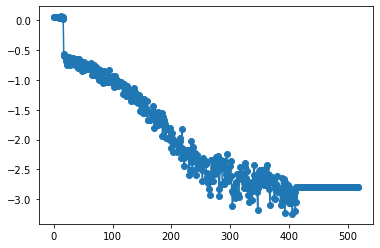

In [21]:
for i in misclassified_indices:
    print(i)
    df = X[i]
    print(f"RUN_ID: {df['run_id'][0]}, TRIAL_ID: {df['trial_id'][0]}, EXP_ID: {df['experiment_id'][0]}")
    
    # Create a figure
    fig, ax = plt.subplots()
    
    ax.plot(np.arange(len(df)), df["x_force"].to_numpy().flatten(), '-o', label='Data Points')
    
    additional_text = f"TRUE: {int(y_class[i])}, PRED: {y_pred_binary[i]}"
    run_id = df["run_id"].unique()[0]
    trial_id = df["trial_id"].unique()[0]
    experiment_id = df["experiment_id"].unique()[0]
    
    individual = labels[labels["run_id"] == run_id]
    individual = individual[individual["experiment_id"] == experiment_id]
    individual = individual[individual["trial_id"] == trial_id]
    
    # Get the row value from the 'individual' DataFrame
    if individual['row'].iloc[0].isnumeric():
        row_value = int(individual['row'])
        print("ROW VALUE: ", row_value)
    else:
        print("NONE")
        continue
    
    ax.text(300, -12, additional_text, horizontalalignment='center', verticalalignment='bottom')
    ax.plot(int(individual["row"]), df.iloc[int(individual["row"])]['x_force'], 'rx', markersize=10, label='Clicked Point')
    
    plt.xlabel('X-axis Label')
    plt.ylabel('Y-axis Label')
    plt.title('Plot Title')
    plt.legend()
    plt.show()
